- References:
    - `OneCycleScheduler` in paper [Super-Convergence: Very Fast Training of Neural
Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120).
    - `fit_one_cylce()` in `Fast AI`. 
    - [Examples of scheduler in Pytorch on Kaggel](https://www.kaggle.com/residentmario/one-cycle-learning-rate-schedulers![image.png](attachment:image.png))
    
- Take away techs:
    - `Scheduler` in `Pytorch` will initialize the params in optimizer when it is used, so `Scheduler.step()` should be called after `optimizer.step()`.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [3]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

### Load CIFAR-10 Dataset

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
# orig_train_ds = tv.datasets.MNIST(root='data/', train=True, download=True, transform=transform)
# orig_test_ds = tv.datasets.MNIST(root='data/', train=False, transform=transform)

In [6]:
orig_train_ds = tv.datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)
orig_test_ds = tv.datasets.CIFAR10(root='data/', train=False, transform=transform)

Files already downloaded and verified


In [7]:
# # Split MNIST Dataset into train and valid
# train_x, valid_x, train_y, valid_y = train_test_split(orig_train_ds.data.unsqueeze(1).float(), orig_train_ds.targets, test_size=0.1)

In [8]:
# Split CIFAR-10 Dataset into train and valid
orig_train_x = torch.from_numpy(orig_train_ds.data.transpose([0,3,1,2])/255.).float()
orig_train_y = torch.from_numpy(np.array(orig_train_ds.targets))
orig_test_x  = torch.from_numpy(orig_test_ds.data.transpose([0,3,1,2])/255.).float()
orig_test_y  = torch.from_numpy(np.array(orig_test_ds.targets))
train_x, valid_x, train_y, valid_y = train_test_split(orig_train_x, orig_train_y, test_size=0.1)

In [9]:
train_ds = TensorDataset(train_x, train_y)
valid_ds = TensorDataset(valid_x, valid_y)
test_ds  = TensorDataset(orig_test_x, orig_test_y)
# test_ds  = TensorDataset(orig_test_ds.data.unsqueeze(1).float(), orig_test_ds.targets)

In [10]:
# Wrap dataset into dataloader
bs = 128
train_dl = DataLoader(dataset=train_ds, batch_size=bs, shuffle=True, num_workers=8)
valid_dl = DataLoader(dataset=valid_ds, batch_size=bs, shuffle=False, num_workers=8)
test_dl  = DataLoader(dataset=test_ds,  batch_size=bs, shuffle=False, num_workers=8)

### Define model

In [11]:
class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

In [12]:
def getNewModel():
    return nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.AdaptiveAvgPool2d((1,1)),
        Flatten(),
        nn.Linear(in_features=128, out_features=32),
        nn.ReLU(),
        nn.Dropout(p=0.2),

        nn.Linear(32, 10),
    )

In [13]:
def trainCharRecog(model, train_loader, optimizer, criterion, lr_list=None, mom_list=None, scheduler=None):
    model.train()
    train_loss = 0.
    total = 0.
    char_correct = 0.
    ang_correct = 0.
    for batch_idx, (imgs, tchar) in enumerate(train_loader):
        if lr_list is not None and mom_list is not None:
            setParamForOpt(optimizer, lr=lr_list[batch_idx], mom=mom_list[batch_idx])
        
        imgs, tchar = imgs.cuda(), tchar.cuda()
        schar = model(imgs)
        loss = criterion(schar, tchar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        _, char_predict = torch.max(schar.data,1)
        
        total += tchar.size(0)
        char_correct += char_predict.eq(tchar.data).cpu().sum().item()
        if scheduler is not None:
            scheduler.step()
        
    return train_loss/batch_idx, char_correct/total

In [14]:
def evalCharRecog(model, test_loader, criterion):
    model.eval()
    valid_loss = 0.
    total = 0.
    char_correct = 0.
    ang_correct = 0.
    with torch.no_grad():
        for batch_idx, (imgs, tchar) in enumerate(test_loader):
            imgs, tchar = imgs.cuda(), tchar.cuda()
            schar = model(imgs)
            loss = criterion(schar, tchar)
            valid_loss += loss.item()

            _, char_predict = torch.max(schar.data,1)
            total += tchar.size(0)
            char_correct += char_predict.eq(tchar.data).cpu().sum().item()
    return valid_loss/batch_idx, char_correct/total

### Train Models in Fast AI Manner use one-cycle strategy

In [15]:
import os
import sys
sys.path.append(os.environ.get("FASTAI_PATH"))

In [16]:
import torch.nn.functional as F

In [17]:
from fastai.vision import *
from fastai.data.core import DataLoaders
from fastai.vision.all import *

In [18]:
data = DataLoaders.from_dsets(train_ds, valid_ds).cuda()

In [19]:
len(data.train_ds)

45000

In [20]:
model_fastai = getNewModel()
criterion = nn.CrossEntropyLoss()

In [21]:
def opt_func(ps, lr): return OptimWrapper(optim.SGD(ps, lr=lr, momentum=0.9, weight_decay=1E-4))

In [22]:
learn = Learner(data, model_fastai, loss_func=criterion, opt_func=opt_func, metrics=accuracy) #F.cross_entropy

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.12022644281387329)

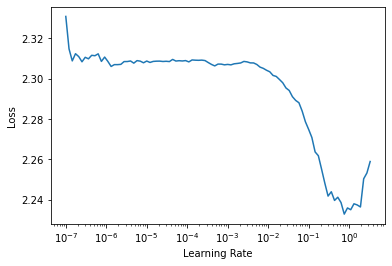

In [23]:
learn.lr_find()

In [24]:
learn.opt.hypers

[{'lr': 0.001, 'mom': 0.9, 'dampening': 0, 'wd': 0.0001, 'nesterov': False}]

In [25]:
learn.recorder.moms

(0.95, 0.85, 0.95)

In [26]:
learn.fit_one_cycle(20, lr_max=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.404161,1.814959,0.373400,00:09
1,1.214754,1.532823,0.467000,00:09
2,1.050042,1.126524,0.595600,00:10
3,1.011254,1.077373,0.616600,00:09
4,0.946479,1.041593,0.633200,00:09
5,0.838020,1.043868,0.649200,00:09
6,0.820052,1.056161,0.651600,00:09
7,0.782668,0.867545,0.704400,00:09
8,0.762623,0.819893,0.719000,00:10
9,0.702591,1.006001,0.663400,00:09


In [27]:
len(data.train)

703

In [28]:
test_loss, test_acc = evalCharRecog(model_fastai, test_dl, criterion)

In [29]:
test_acc

0.755

### One Cycle Implementation 

- Steps:
    - 1. Create the lr list and the momentum list using cosine.
    - 2. Create the scheduler object.
    - 3. Train classifiers.

In [30]:
model = getNewModel()
model = model.cuda()

In [31]:
lr_max = 0.1
lr_start = lr_max/25.
lr_end = lr_max/1e5
mom_min = 0.85
mom_start = 0.95
mom_end = 0.95

In [32]:
n_epochs = 20
n_iter_one_epoch = len(train_dl)
n_iters = len(train_dl)*n_epochs
n_pct = 0.25

In [33]:
n_first_half = np.int(n_iters*n_pct)
n_second_half = n_iters - n_first_half

In [34]:
lr_first_half = (np.cos(np.pi*(1-np.arange(n_first_half)/n_first_half))+1)/2*(lr_max-lr_start)+lr_start
lr_second_half = (np.cos(np.pi*(1-np.arange(n_second_half)/n_second_half))+1)/2*(lr_end-lr_max)+lr_max
lr_list = np.concatenate([lr_first_half, lr_second_half])

mom_first_half = (np.cos(np.pi*(1-np.arange(n_first_half)/n_first_half))+1)/2*(mom_min-mom_start)+mom_start
mom_second_half = (np.cos(np.pi*(1-np.arange(n_second_half)/n_second_half))+1)/2*(mom_end-mom_min)+mom_min
mom_list = np.concatenate([mom_first_half, mom_second_half])

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1E-2, momentum=0.9, weight_decay=1E-4)

In [36]:
def setParamForOpt(opt, lr, mom):
    for param in opt.param_groups:
        param["lr"] = lr
        param["momentum"] = mom

In [37]:
train_loss_hist = []
valid_loss_hist = []
train_char_acc_hist = []
train_ang_acc_hist = []
valid_char_acc_hist = []
valid_ang_acc_hist = []
# correct = 0
# total = 0

In [38]:
for epoch in tqdm(range(n_epochs)):
    beg_indx = epoch*n_iter_one_epoch
    end_indx = (epoch+1)*n_iter_one_epoch
    train_loss, train_char_acc = trainCharRecog(model, train_dl, optimizer, criterion, 
                                                lr_list[beg_indx:end_indx], mom_list[beg_indx:end_indx])
    
    
    
    valid_loss, valid_char_acc = evalCharRecog(model, valid_dl, criterion)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)
    train_char_acc_hist.append(train_char_acc)
    valid_char_acc_hist.append(valid_char_acc)
    


100%|██████████| 20/20 [01:15<00:00,  3.78s/it]


In [39]:
test_loss, test_acc = evalCharRecog(model, test_dl, criterion)

In [40]:
test_acc

0.7498

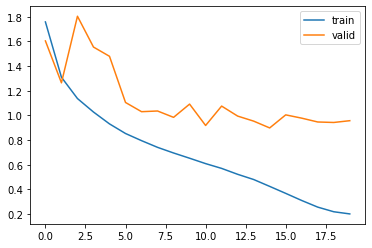

In [41]:
plt.plot(train_loss_hist, label="train")
plt.plot(valid_loss_hist, label="valid")
plt.legend()

Text(0, 0.5, 'Acc of Chars')

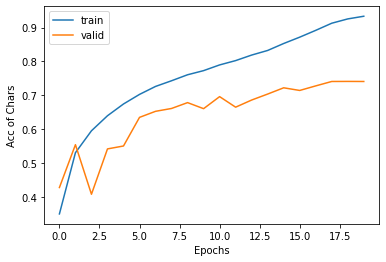

In [42]:
plt.plot(train_char_acc_hist, label="train")
plt.plot(valid_char_acc_hist, label="valid")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Acc of Chars")

### Train models use OneCycleLR in Pytorch

In [43]:
torch.backends.cudnn.benchmark = True

In [44]:
# model = CharRecogModel()
model = getNewModel()
model = model.cuda()

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1E-2, momentum=0.9, weight_decay=1E-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=n_iter_one_epoch, epochs=n_epochs)

In [46]:
train_loss_hist = []
valid_loss_hist = []
train_char_acc_hist = []
train_ang_acc_hist = []
valid_char_acc_hist = []
valid_ang_acc_hist = []
# correct = 0
# total = 0

In [47]:
for epoch in tqdm(range(n_epochs)):
    train_loss, train_char_acc = trainCharRecog(model, train_dl, optimizer, criterion, scheduler=scheduler)
    
    
    valid_loss, valid_char_acc = evalCharRecog(model, valid_dl, criterion)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)
    train_char_acc_hist.append(train_char_acc)
    valid_char_acc_hist.append(valid_char_acc)
    


100%|██████████| 20/20 [01:16<00:00,  3.84s/it]


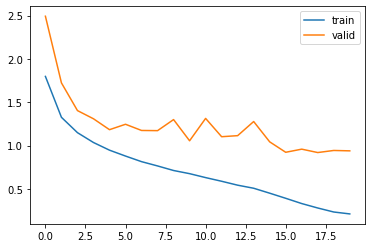

In [48]:
plt.plot(train_loss_hist, label="train")
plt.plot(valid_loss_hist, label="valid")
plt.legend()

Text(0, 0.5, 'Acc of Chars')

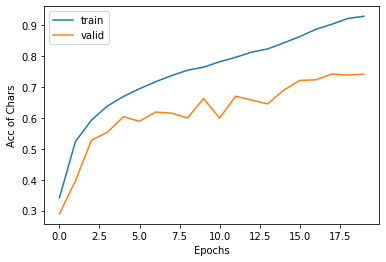

In [49]:
plt.plot(train_char_acc_hist, label="train")
plt.plot(valid_char_acc_hist, label="valid")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Acc of Chars")

In [50]:
test_loss, test_acc = evalCharRecog(model, test_dl, criterion)

In [51]:
test_acc

0.7412

### Train models use OneCycleLR in Pytorch

In [52]:
torch.backends.cudnn.benchmark = True

In [53]:
# model = CharRecogModel()
model = getNewModel()
model = model.cuda()

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1E-2, momentum=0.9, weight_decay=1E-4)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=n_iter_one_epoch, epochs=n_epochs)

In [55]:
train_loss_hist = []
valid_loss_hist = []
train_char_acc_hist = []
train_ang_acc_hist = []
valid_char_acc_hist = []
valid_ang_acc_hist = []
# correct = 0
# total = 0

In [56]:
for epoch in tqdm(range(n_epochs)):
    train_loss, train_char_acc = trainCharRecog(model, train_dl, optimizer, criterion)
    
    
    valid_loss, valid_char_acc = evalCharRecog(model, valid_dl, criterion)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)
    train_char_acc_hist.append(train_char_acc)
    valid_char_acc_hist.append(valid_char_acc)
    


100%|██████████| 20/20 [01:17<00:00,  3.87s/it]


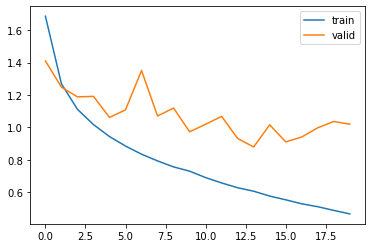

In [57]:
plt.plot(train_loss_hist, label="train")
plt.plot(valid_loss_hist, label="valid")
plt.legend()

Text(0, 0.5, 'Acc of Chars')

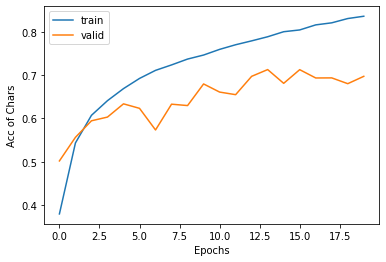

In [58]:
plt.plot(train_char_acc_hist, label="train")
plt.plot(valid_char_acc_hist, label="valid")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Acc of Chars")

In [59]:
test_loss, test_acc = evalCharRecog(model, test_dl, criterion)

In [60]:
test_acc

0.6872